# TCL 1D: MF bridge vs single‑agent extremes
This notebook re-implements the **bridge (hard-marginal)** TCL example in 1D.

We compare three controlled processes that all match the same terminal Gaussian target:
- **MF bridge** (mean-field coupling)
- **IA(\bar m=0)**: independent-agent(s) with running cost centered at 0
- **IA(\bar m=m^tar)**: independent-agent(s) with running cost centered at the target

All three share the **same Riccati coefficient** $S_t$ (variance channel), determined by the bridge constraint $\Sigma_1=\sigma_{\rm tar}^2$. They differ only in the linear coefficient $s_t$ (mean channel).


In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 140

import os
os.makedirs("figures", exist_ok=True)



## Parameters
We consider the uncontrolled OU drift $f(x)=-\kappa x$ with unit diffusion and horizon $t\in[0,1]$.
Target terminal marginal: $\mathcal N(m^{(\mathrm{tar})},\sigma_{\rm tar}^2)$.
Running quadratic weight: $q\ge 0$.


In [2]:
# Parameters
"""
kappa = 1.0
q     = 1.0
m_tar = 1.0
sigma_tar = 0.6
"""
kappa = 0.6
q = 12.0
m_tar = 2.0
sigma_tar = 0.5

# Time grid for analytic objects (fine)
T = 1.0
N = 4001
t = np.linspace(0.0, T, N)
dt = t[1] - t[0]

print("kappa =", kappa, " q =", q)
print("target mean =", m_tar, " target std =", sigma_tar)


kappa = 0.6  q = 12.0
target mean = 2.0  target std = 0.5


## Bridge Riccati coefficient $S_t$
For all three methods we use the same scalar Riccati ODE
$$\dot S = S^2 + 2\kappa S - q,$$
but **$S_1$ is not imposed**. Instead we parameterize the solution by the ratio
$$\rho=\frac{S_1+\kappa-\Delta}{S_1+\kappa+\Delta},\qquad \Delta=\sqrt{\kappa^2+q},$$
and determine $\rho$ from the bridge variance constraint $\Sigma_1=\sigma_{\rm tar}^2$.

**Closed form:**
$$S_t=-\kappa+\Delta\,\frac{1+\rho e^{2\Delta(t-1)}}{1-\rho e^{2\Delta(t-1)}}.$$
The corresponding covariance solves
$$\dot\Sigma=-2(\kappa+S_t)\Sigma+1,\quad \Sigma_0=0.$$
In 1D the terminal constraint yields an explicit algebraic solution for $\rho$:
$$\rho=\frac{2\Delta\sigma_{\rm tar}^2+e^{-2\Delta}-1}{2\Delta\sigma_{\rm tar}^2 e^{-2\Delta}+e^{-2\Delta}-1}.$$


In [3]:
def rho_from_sigma(kappa: float, q: float, sigma_tar: float) -> float:
    Delta = np.sqrt(kappa**2 + q)
    r0 = np.exp(-2*Delta)
    num = 2*Delta*sigma_tar**2 + r0 - 1
    den = 2*Delta*sigma_tar**2 * r0 + r0 - 1
    return num/den

def S_of_t(t: np.ndarray, kappa: float, q: float, rho: float) -> np.ndarray:
    Delta = np.sqrt(kappa**2 + q)
    E = np.exp(2*Delta*(t-1.0))
    return -kappa + Delta*(1 + rho*E)/(1 - rho*E)

rho = rho_from_sigma(kappa, q, sigma_tar)
S = S_of_t(t, kappa, q, rho)
Delta = np.sqrt(kappa**2 + q)

print("Delta =", Delta)
print("rho   =", rho)
print("S(t=1-) approx =", S[-1])


Delta = 3.515679166249389
rho   = -0.7605769821241912
S(t=1-) approx = -0.1218984887267145


### Covariance trajectory $\Sigma_t$
We integrate $\dot\Sigma=-2(\kappa+S_t)\Sigma+1$ forward from $\Sigma_0=0$ (degenerate-Gaussian limit).
This should land at $\Sigma_1\approx\sigma_{\rm tar}^2$ by construction.


In [4]:
def integrate_sigma(t: np.ndarray, S: np.ndarray, kappa: float) -> np.ndarray:
    dt = t[1]-t[0]
    Sigma = np.zeros_like(t)
    for i in range(len(t)-1):
        Sigma[i+1] = Sigma[i] + (-2*(kappa + S[i])*Sigma[i] + 1.0)*dt
    return Sigma

Sigma = integrate_sigma(t, S, kappa)
print("Sigma(1) =", Sigma[-1], " target =", sigma_tar**2)


Sigma(1) = 0.24993404846748132  target = 0.25


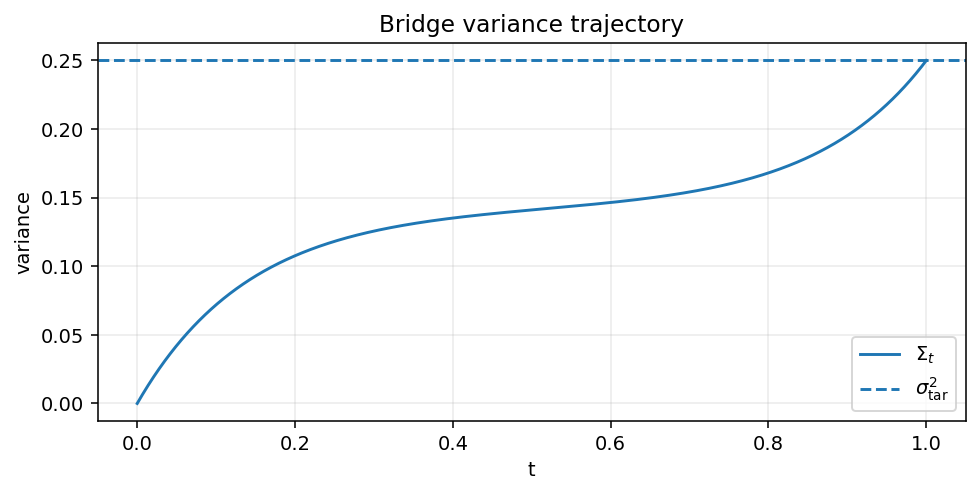

In [6]:
fig, ax = plt.subplots(figsize=(8,3.5))
ax.plot(t, Sigma, label=r"$\Sigma_t$")
ax.axhline(sigma_tar**2, linestyle="--", linewidth=1.5, label=r"$\sigma_{\rm tar}^2$")
ax.set_xlabel("t"); ax.set_ylabel("variance")
ax.set_title("Bridge variance trajectory")
ax.grid(alpha=0.25); ax.legend()
plt.show()


## Linear coefficient $s_t$ for each method
All methods use the same controlled SDE
$$dx_t = (-(\kappa+S_t)x_t - s_t)\,dt + dW_t,$$
and differ only in how $s_t$ is constructed.

### MF bridge
The MF mean satisfies the closed ODE $\ddot m-\kappa^2 m=0$ with $m_0=0,\ m_1=m^{(\mathrm{tar})}$, hence
$$m_t^{(MF)}=m^{(\mathrm{tar})}\,\frac{\sinh(\kappa t)}{\sinh(\kappa)}.$$
Then
$$s_t^{(MF)}=-\dot m_t^{(MF)}-(\kappa+S_t)m_t^{(MF)}.$$

### IA (independent-agents) with fixed center $\bar m$
For IA, $\bar m$ is constant (either 0 or $m^{(\mathrm{tar})}$). The pair $(m_t,s_t)$ solves
$$\dot s = q\,\bar m + (\kappa+S_t)s,\qquad \dot m = -(\kappa+S_t)m - s,\qquad m_0=0.$$
We choose $s_0$ by **one-dimensional shooting** to satisfy the bridge mean constraint $m_1=m^{(\mathrm{tar})}$.


In [7]:
def mf_m_and_s(t: np.ndarray, kappa: float, S: np.ndarray, m_tar: float):
    # mean
    m = m_tar * np.sinh(kappa*t) / np.sinh(kappa)
    mdot = kappa * m_tar * np.cosh(kappa*t) / np.sinh(kappa)
    s = -mdot - (kappa + S)*m
    return m, s

def se_m_and_s_by_shooting(t: np.ndarray, kappa: float, q: float, S: np.ndarray, m_tar: float, mbar: float):
    dt = t[1]-t[0]
    def forward(s0):
        m = 0.0
        s = s0
        m_path = np.zeros_like(t)
        s_path = np.zeros_like(t)
        for i in range(len(t)):
            m_path[i]=m
            s_path[i]=s
            if i < len(t)-1:
                s = s + (q*mbar + (kappa + S[i])*s)*dt
                m = m + (-(kappa + S[i])*m - s_path[i])*dt  # use s at time i (explicit Euler)
        return m_path, s_path
    # linear shooting using two runs
    m0, s0_path = forward(0.0)
    m1, s1_path = forward(1.0)
    m1_end0 = m0[-1]
    m1_end1 = m1[-1]
    if abs(m1_end1 - m1_end0) < 1e-14:
        raise RuntimeError("Degenerate shooting: m1 does not depend on s0.")
    s0_star = (m_tar - m1_end0) / (m1_end1 - m1_end0)
    m_star, s_star = forward(s0_star)
    return s0_star, m_star, s_star

m_mf, s_mf = mf_m_and_s(t, kappa, S, m_tar)

s0_se0, m_se0, s_se0 = se_m_and_s_by_shooting(t, kappa, q, S, m_tar, mbar=0.0)
s0_set, m_set, s_set = se_m_and_s_by_shooting(t, kappa, q, S, m_tar, mbar=m_tar)

print("MF:  m(1)=", m_mf[-1], "Sigma(1)=", Sigma[-1])
print("IA0: s0=", s0_se0, " m(1)=", m_se0[-1])
print("IAt: s0=", s0_set, " m(1)=", m_set[-1])


MF:  m(1)= 2.0 Sigma(1)= 0.24993404846748132
IA0: s0= -0.41890862759595593  m(1)= 2.0000000000000067
IAt: s0= -6.8506129151430875  m(1)= 1.99999999999968


### Sanity plots: theoretical means and linear coefficients
These curves are what we will compare to Monte-Carlo trajectory ensembles.


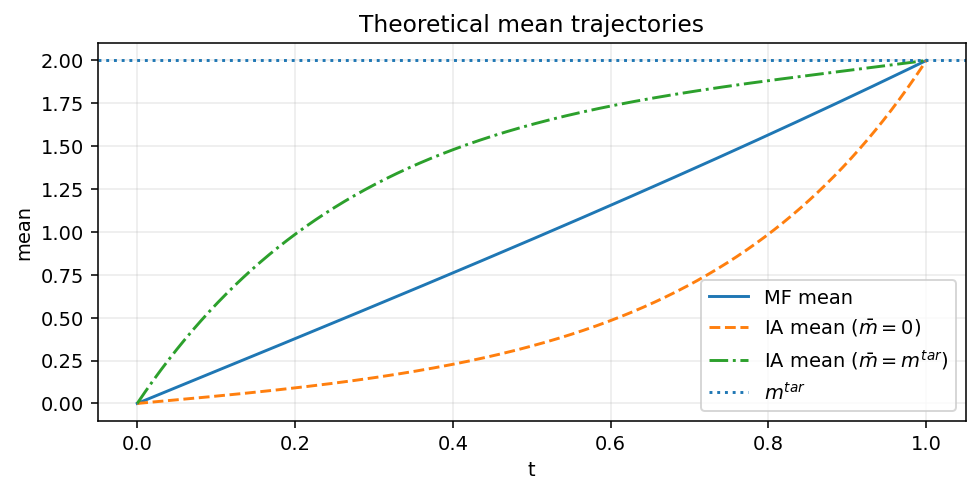

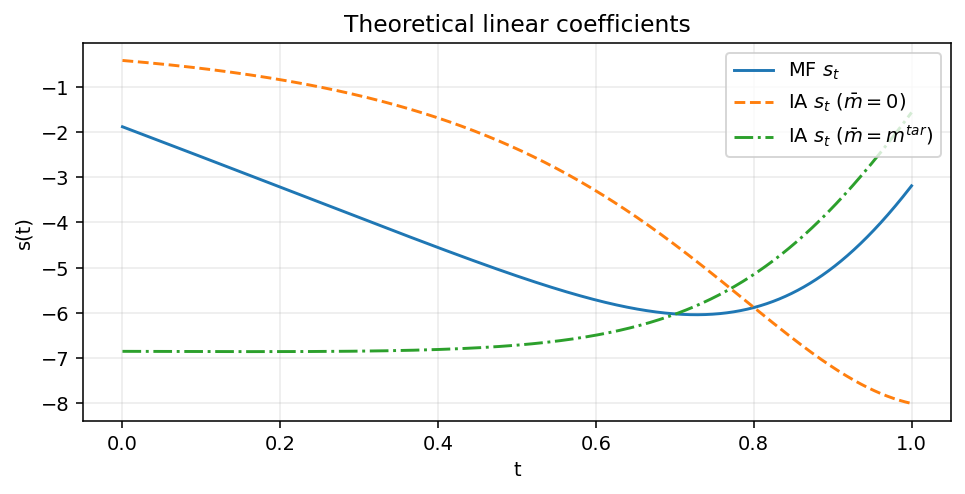

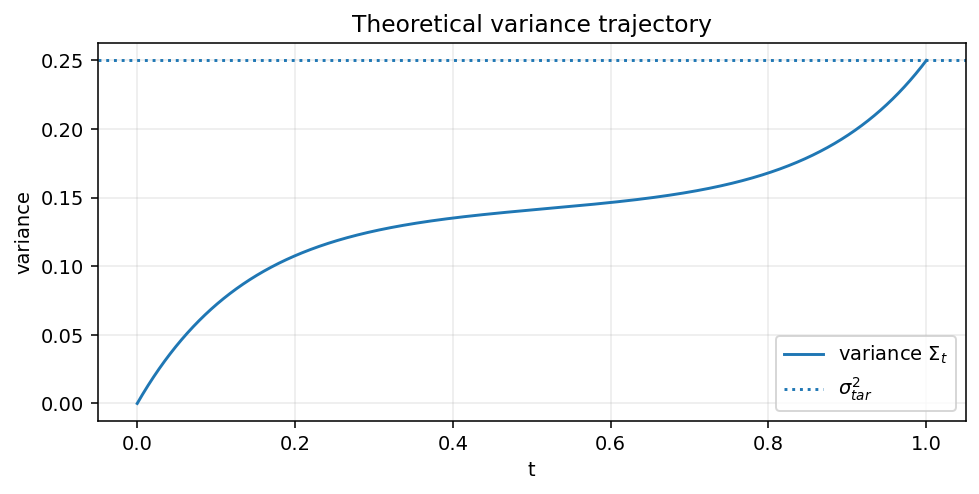

In [8]:
fig, ax = plt.subplots(figsize=(8,3.5))
ax.plot(t, m_mf, label="MF mean")
ax.plot(t, m_se0, "--", label=r"IA mean ($\bar m=0$)")
ax.plot(t, m_set, "-.", label=r"IA mean ($\bar m=m^{tar}$)")
ax.axhline(m_tar, linestyle=":", linewidth=1.5, label=r"$m^{tar}$")
ax.set_xlabel("t"); ax.set_ylabel("mean")
ax.set_title("Theoretical mean trajectories")
ax.grid(alpha=0.25); ax.legend()
plt.show()

fig, ax = plt.subplots(figsize=(8,3.5))
ax.plot(t, s_mf, label="MF $s_t$")
ax.plot(t, s_se0, "--", label=r"IA $s_t$ ($\bar m=0$)")
ax.plot(t, s_set, "-.", label=r"IA $s_t$ ($\bar m=m^{tar}$)")
ax.set_xlabel("t"); ax.set_ylabel("s(t)")
ax.set_title("Theoretical linear coefficients")
ax.grid(alpha=0.25); ax.legend()
plt.show()

# --- Analytic variance curves ---
fig, ax = plt.subplots(figsize=(8,3.5))

# If you already computed Sigma(t) on the same grid as t, use it directly.
# (In this TCL setup, variance is the same for MF and both SE variants since S_t is shared.)
ax.plot(t, Sigma, label=r"variance $\Sigma_t$")

ax.axhline(sigma_tar**2, linestyle=":", linewidth=1.5, label=r"$\sigma_{tar}^2$")
ax.set_xlabel("t"); ax.set_ylabel("variance")
ax.set_title("Theoretical variance trajectory")
ax.grid(alpha=0.25); ax.legend()
plt.show()


## Simulation (Euler–Maruyama)
We simulate
$$dx_t = (-(\kappa+S_t)x_t - s_t)\,dt + dW_t,$$
using the same time grid for drift coefficients and EM time step.
We generate trajectory ensembles and compare:
- empirical mean/variance at each time
- terminal histogram against the target Gaussian.


In [9]:
import math

def simulate_em(t: np.ndarray, kappa: float, S: np.ndarray, s: np.ndarray, n_paths: int, seed: int=0):
    rng = np.random.default_rng(seed)
    dt = t[1]-t[0]
    X = np.zeros((n_paths, len(t)))
    for b in range(n_paths):
        x = 0.0
        for i in range(len(t)):
            X[b,i]=x
            if i < len(t)-1:
                drift = -(kappa + S[i])*x - s[i]
                x = x + drift*dt + math.sqrt(dt)*rng.standard_normal()
    return X

B = 20000
X_mf  = simulate_em(t, kappa, S, s_mf,  B, seed=1)
X_se0 = simulate_em(t, kappa, S, s_se0, B, seed=2)
X_set = simulate_em(t, kappa, S, s_set, B, seed=3)

def emp_moments(X):
    m = X.mean(axis=0)
    v = X.var(axis=0)
    return m,v

mhat_mf, vhat_mf   = emp_moments(X_mf)
mhat_se0, vhat_se0 = emp_moments(X_se0)
mhat_set, vhat_set = emp_moments(X_set)

print("Empirical terminal (MF):  mean=", mhat_mf[-1], " var=", vhat_mf[-1])
print("Empirical terminal (IA0): mean=", mhat_se0[-1], " var=", vhat_se0[-1])
print("Empirical terminal (IAt): mean=", mhat_set[-1], " var=", vhat_set[-1])
print("Target: mean=", m_tar, " var=", sigma_tar**2)


Empirical terminal (MF):  mean= 2.003411005425235  var= 0.24761998063474702
Empirical terminal (IA0): mean= 1.9989857496590928  var= 0.249658129385152
Empirical terminal (IAt): mean= 2.0045563634526324  var= 0.2491098748880599
Target: mean= 2.0  var= 0.25


### Trajectory ensemble visualization
We plot a moderate number of sample paths for each method, and overlay the theoretical mean curves and the target band.


Saved: figures/fig_ensemble_kappa=0.6_q=12.0_mtar=2.0_sig=0.5.png


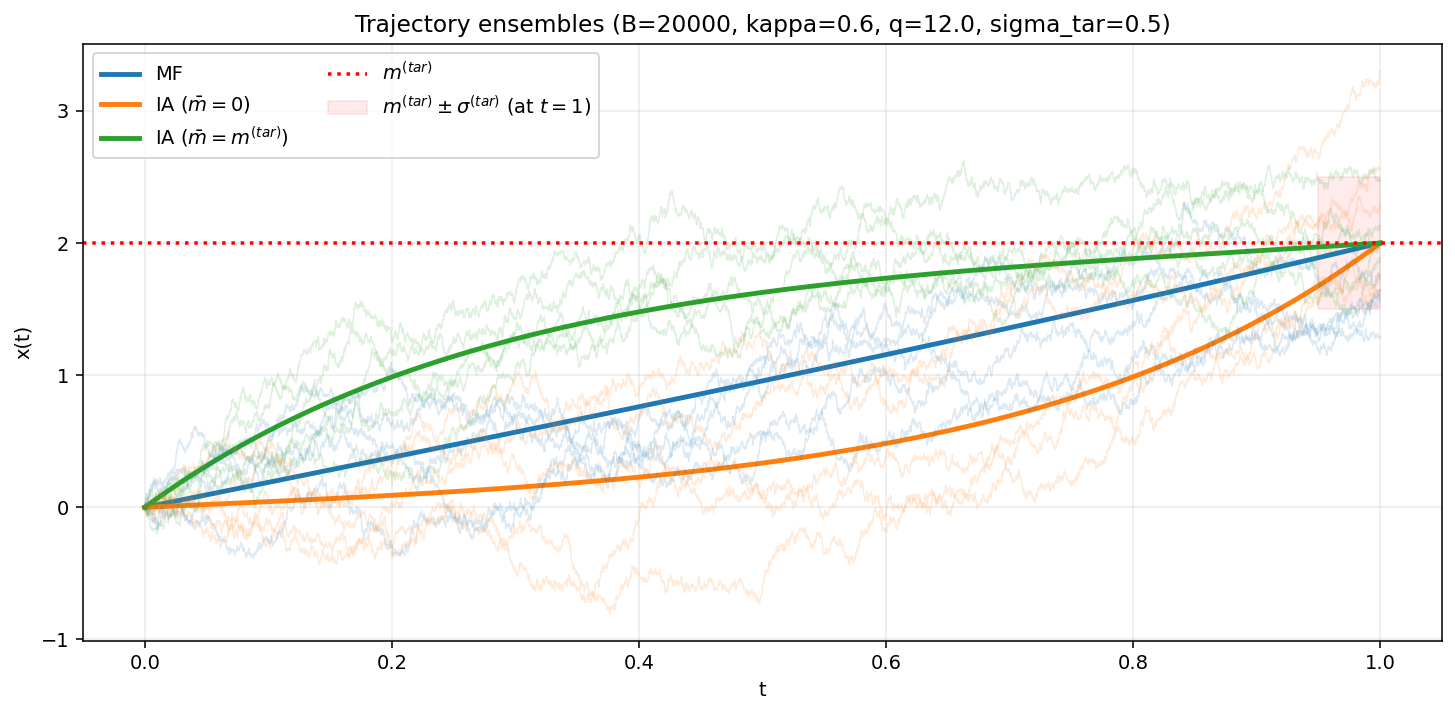

In [11]:
def plot_ensemble(Xs, labels, t, means, m_tar, sigma_tar, n_show=40, title=""):
    fig, ax = plt.subplots(figsize=(10.5, 5.2))

    # Get a stable color per scheme by plotting the mean first (and capturing its color)
    scheme_colors = []
    for mean, lab in zip(means, labels):
        line, = ax.plot(t, mean, linewidth=2.5, label=lab)
        scheme_colors.append(line.get_color())

    # Now plot trajectories using the same color as the corresponding mean
    for X, col in zip(Xs, scheme_colors):
        n = min(n_show, X.shape[0])
        for i in range(n):
            ax.plot(t, X[i], color=col, alpha=0.15, linewidth=0.8)

    # Target mean/variance markers
    ax.axhline(m_tar, color="red", linestyle=":", linewidth=1.8, label=r"$m^{(tar)}$")
    ax.fill_between([0.95, 1.0], m_tar - sigma_tar, m_tar + sigma_tar,
                    color="red", alpha=0.08,
                    label=r"$m^{(tar)}\pm\sigma^{(tar)}$ (at $t=1$)")

    ax.set_xlabel("t")
    ax.set_ylabel("x(t)")
    ax.set_title(title)
    ax.grid(alpha=0.25)
    ax.legend(ncol=2)
    plt.tight_layout()

    # --- Save figure ---
    fname = f"figures/fig_ensemble_kappa={kappa}_q={q}_mtar={m_tar}_sig={sigma_tar}.png"
    plt.tight_layout()
    plt.savefig(fname, dpi=300, bbox_inches="tight")
    print(f"Saved: {fname}")

    
    plt.show()




plot_ensemble(
    [X_mf, X_se0, X_set],
    ["MF", r"IA ($\bar m=0$)", r"IA ($\bar m=m^{(tar)}$)"],
    t,
    [m_mf, m_se0, m_set],
    m_tar, sigma_tar,
    n_show=5,
    title=f"Trajectory ensembles (B={B}, kappa={kappa}, q={q}, sigma_tar={sigma_tar})"
)


In [12]:
from math import erf, sqrt

def frac_outside_1sigma(X, m_tar, sigma_tar):
    x1 = X[:, -1]
    return np.mean(np.abs(x1 - m_tar) > sigma_tar)

for name, X in [("MF", X_mf), ("IA0", X_se0), ("IAt", X_set)]:
    print(name, "frac outside ±1σ:", frac_outside_1sigma(X, m_tar, sigma_tar))

# Theoretical Gaussian value:
theory_out = 1 - erf(1/sqrt(2))  # ≈ 0.3173
print("Gaussian theory frac outside ±1σ:", theory_out)


MF frac outside ±1σ: 0.3166
IA0 frac outside ±1σ: 0.31835
IAt frac outside ±1σ: 0.314
Gaussian theory frac outside ±1σ: 0.31731050786291415


### Mean and variance: theory vs Monte-Carlo
Theory variance is shared: $\Sigma_t$.
Theory mean is method-dependent.


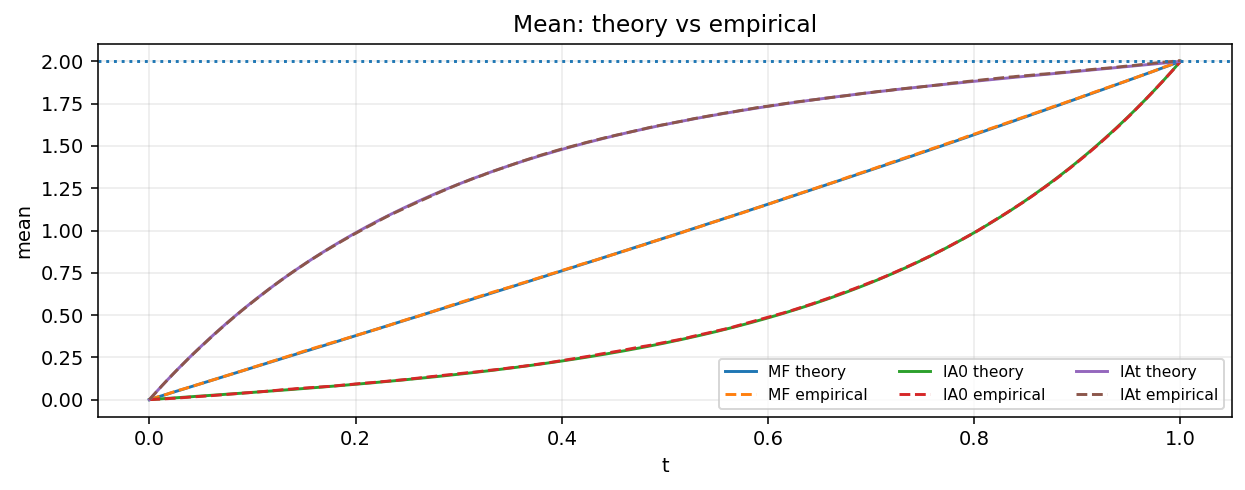

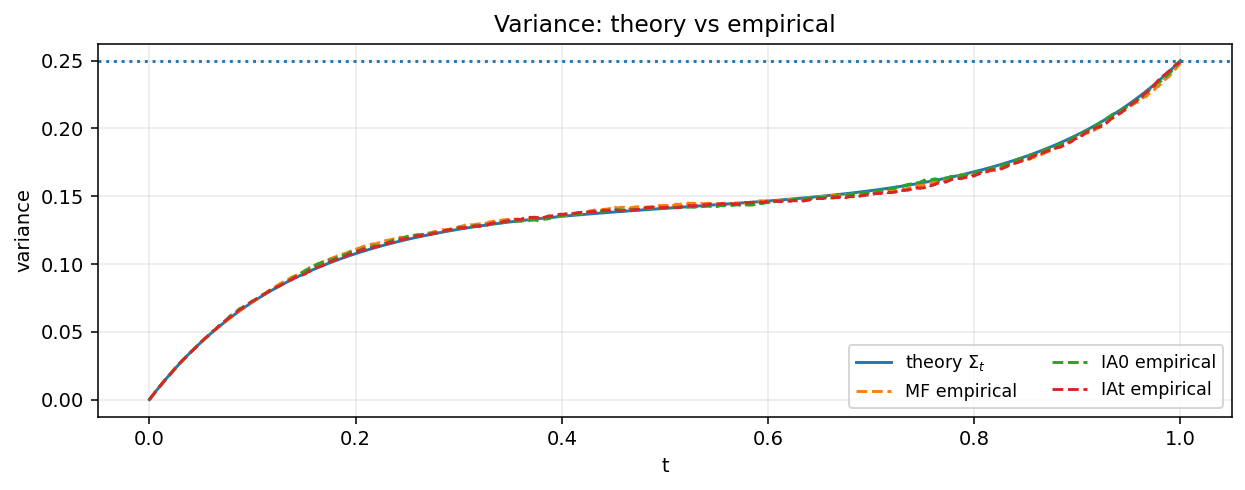

In [13]:
fig, ax = plt.subplots(figsize=(9,3.6))
ax.plot(t, m_mf, label="MF theory")
ax.plot(t, mhat_mf, "--", label="MF empirical")
ax.plot(t, m_se0, label=r"IA0 theory")
ax.plot(t, mhat_se0, "--", label=r"IA0 empirical")
ax.plot(t, m_set, label=r"IAt theory")
ax.plot(t, mhat_set, "--", label=r"IAt empirical")
ax.axhline(m_tar, linestyle=":", linewidth=1.5)
ax.set_xlabel("t"); ax.set_ylabel("mean")
ax.set_title("Mean: theory vs empirical")
ax.grid(alpha=0.25); ax.legend(ncol=3, fontsize=8)
plt.tight_layout(); plt.show()

fig, ax = plt.subplots(figsize=(9,3.6))
ax.plot(t, Sigma, label="theory $\Sigma_t$")
ax.plot(t, vhat_mf, "--", label="MF empirical")
ax.plot(t, vhat_se0, "--", label="IA0 empirical")
ax.plot(t, vhat_set, "--", label="IAt empirical")
ax.axhline(sigma_tar**2, linestyle=":", linewidth=1.5)
ax.set_xlabel("t"); ax.set_ylabel("variance")
ax.set_title("Variance: theory vs empirical")
ax.grid(alpha=0.25); ax.legend(ncol=2, fontsize=9)
plt.tight_layout(); plt.show()


### Terminal distribution check
We compare terminal samples to the target Gaussian density.


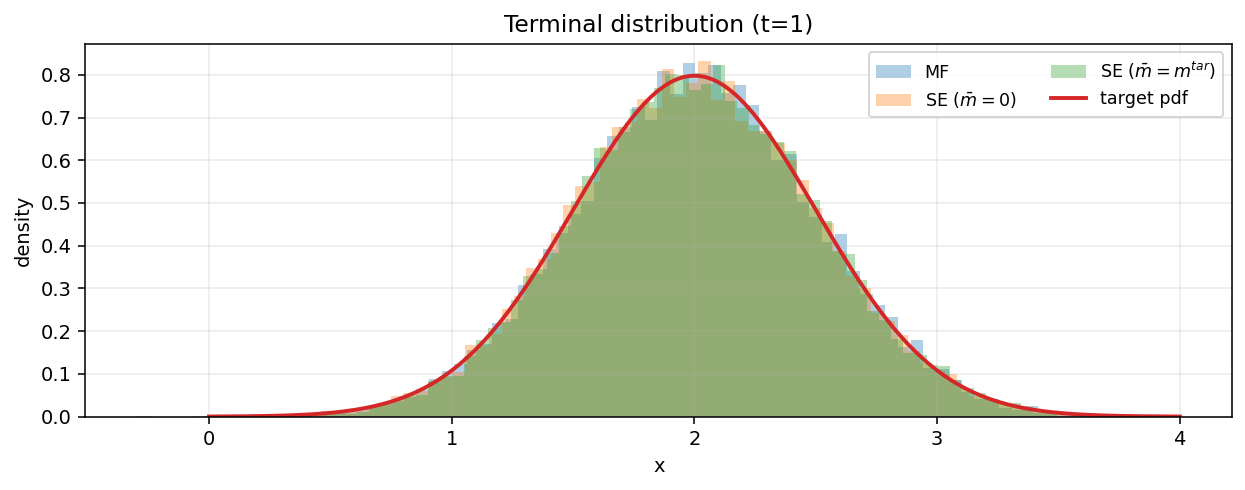

In [14]:
from math import sqrt, pi, exp
def normal_pdf(x, mu, sig):
    return (1/(sig*sqrt(2*pi))) * np.exp(-0.5*((x-mu)/sig)**2)

xgrid = np.linspace(m_tar-4*sigma_tar, m_tar+4*sigma_tar, 400)
pdf_tar = normal_pdf(xgrid, m_tar, sigma_tar)

fig, ax = plt.subplots(figsize=(9,3.6))
ax.hist(X_mf[:,-1], bins=80, density=True, alpha=0.35, label="MF")
ax.hist(X_se0[:,-1], bins=80, density=True, alpha=0.35, label=r"SE ($\bar m=0$)")
ax.hist(X_set[:,-1], bins=80, density=True, alpha=0.35, label=r"SE ($\bar m=m^{tar}$)")
ax.plot(xgrid, pdf_tar, linewidth=2.0, label="target pdf")
ax.set_title("Terminal distribution (t=1)")
ax.set_xlabel("x"); ax.set_ylabel("density")
ax.grid(alpha=0.25); ax.legend(ncol=2, fontsize=9)
plt.tight_layout(); plt.show()


## Summary
With the corrected bridge construction:
- All methods match $\Sigma_1=\sigma_{\rm tar}^2$ by the shared Riccati/variance channel.
- All methods are forced to match $m_1=m^{(\mathrm{tar})}$ by selecting the appropriate linear coefficient trajectory $s_t$.
- MF differs from SE only through the MF-consistent $s_t$ derived from the MF mean trajectory.


Saved: figures/fig_power_kappa=0.6_q=12.0_mtar=2.0_sig=0.5.png


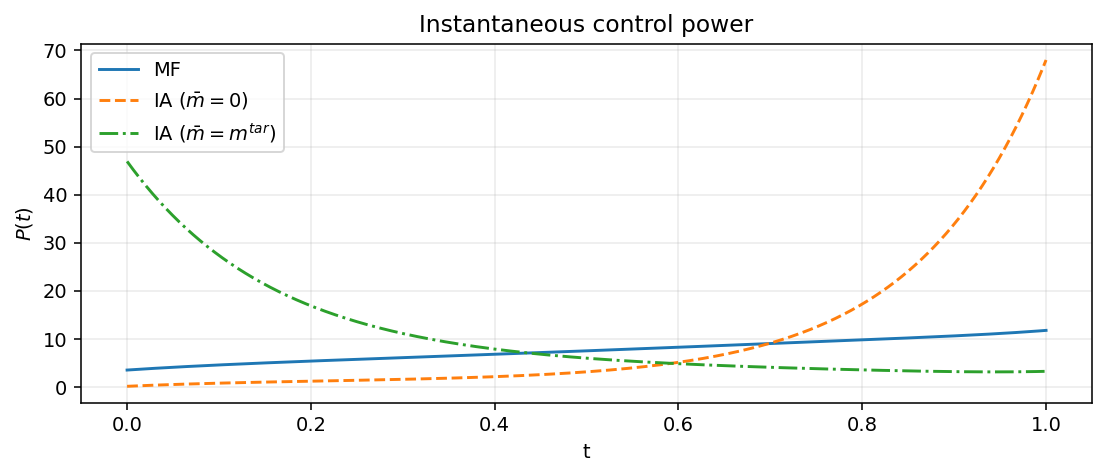

Saved: figures/fig_energy_kappa=0.6_q=12.0_mtar=2.0_sig=0.5.png


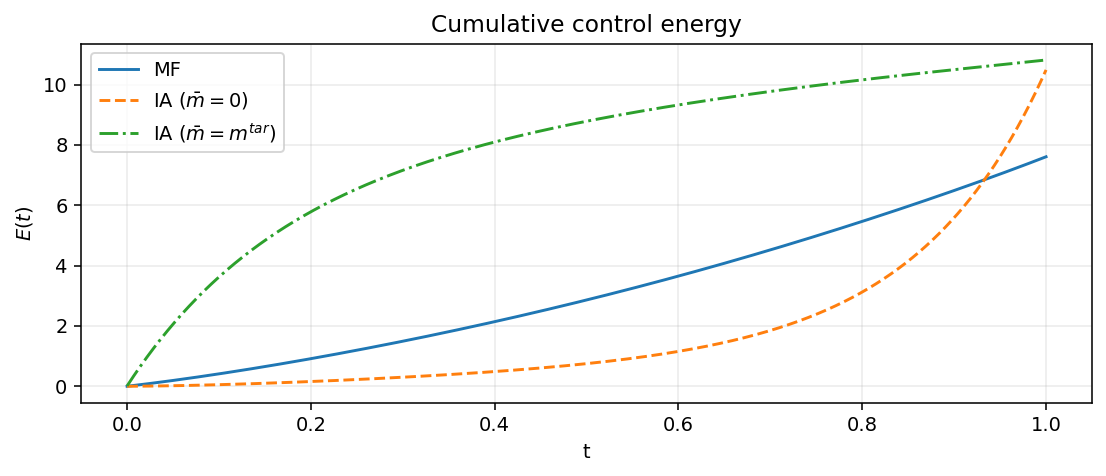

Saved: figures/fig_mean_control_kappa=0.6_q=12.0_mtar=2.0_sig=0.5.png


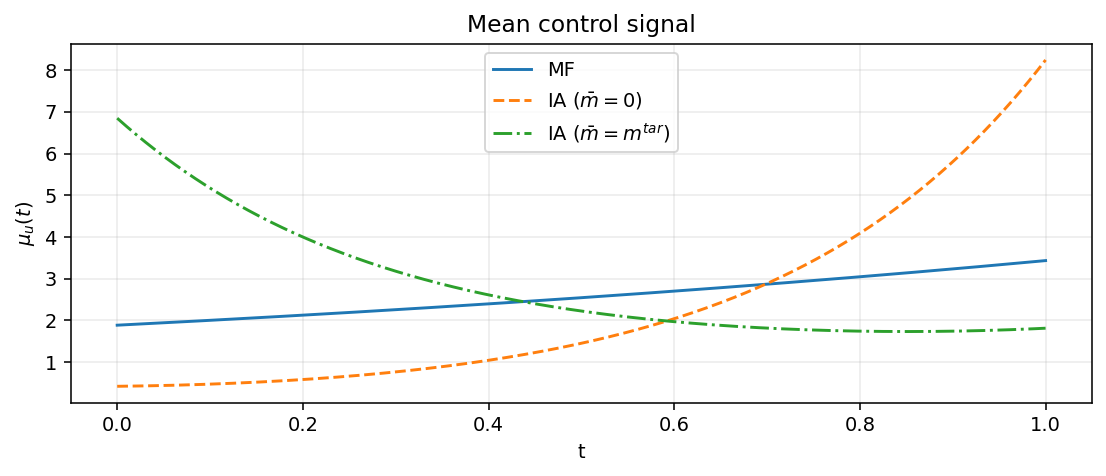

In [15]:
# ------------------------------------------------------------
# Analytic performance metrics: MF vs SA
# ------------------------------------------------------------

def compute_metrics(S, Sigma, m, s):
    power = S**2 * Sigma + (S*m + s)**2
    energy = np.cumsum(power) * (t[1] - t[0])
    mu_u = -(S*m + s)
    sigma_u = np.sqrt(S**2 * Sigma)
    return power, energy, mu_u, sigma_u


# Compute for all three schemes
P_mf,  E_mf,  mu_mf,  sig_mf  = compute_metrics(S, Sigma, m_mf,  s_mf)
P_se0, E_se0, mu_se0, sig_se0 = compute_metrics(S, Sigma, m_se0, s_se0)
P_set, E_set, mu_set, sig_set = compute_metrics(S, Sigma, m_set, s_set)




# --- Plot 1: Instantaneous power ---
fig, ax = plt.subplots(figsize=(8,3.5))
ax.plot(t, P_mf,  label="MF")
ax.plot(t, P_se0, "--", label=r"IA ($\bar m=0$)")
ax.plot(t, P_set, "-.", label=r"IA ($\bar m=m^{tar}$)")
ax.set_xlabel("t")
ax.set_ylabel(r"$ P(t)$")
ax.set_title("Instantaneous control power")
ax.grid(alpha=0.25)
ax.legend()

# --- Save figure ---
fname = f"figures/fig_power_kappa={kappa}_q={q}_mtar={m_tar}_sig={sigma_tar}.png"
plt.tight_layout()
plt.savefig(fname, dpi=300, bbox_inches="tight")
print(f"Saved: {fname}")

plt.show()



# --- Plot 2: Cumulative energy ---
fig, ax = plt.subplots(figsize=(8,3.5))
ax.plot(t, E_mf,  label="MF")
ax.plot(t, E_se0, "--", label=r"IA ($\bar m=0$)")
ax.plot(t, E_set, "-.", label=r"IA ($\bar m=m^{tar}$)")
ax.set_xlabel("t")
ax.set_ylabel(r"$E(t)$")
ax.set_title("Cumulative control energy")
ax.grid(alpha=0.25)
ax.legend()


fname = f"figures/fig_energy_kappa={kappa}_q={q}_mtar={m_tar}_sig={sigma_tar}.png"
plt.tight_layout()
plt.savefig(fname, dpi=300, bbox_inches="tight")
print(f"Saved: {fname}")
plt.show()




# --- Plot 3: Mean control signal ---
fig, ax = plt.subplots(figsize=(8,3.5))
ax.plot(t, mu_mf,  label="MF")
ax.plot(t, mu_se0, "--", label=r"IA ($\bar m=0$)")
ax.plot(t, mu_set, "-.", label=r"IA ($\bar m=m^{tar}$)")
ax.set_xlabel("t")
ax.set_ylabel(r"$\mu_u(t)$")
ax.set_title("Mean control signal")
ax.grid(alpha=0.25)
ax.legend()


fname = f"figures/fig_mean_control_kappa={kappa}_q={q}_mtar={m_tar}_sig={sigma_tar}.png"
plt.tight_layout()
plt.savefig(fname, dpi=300, bbox_inches="tight")
print(f"Saved: {fname}")

plt.show()